In [5]:
%load_ext autoreload
%autoreload 1
%aimport environment

from environment import CarEnv

import numpy as np

import matplotlib.pyplot as plt

In [8]:
env = CarEnv(0, False)
print(env.observation_space.shape) # size of the image
print(env.action_space) 
action_dim = env.action_space.n

(40, 40, 3)
Discrete(6)


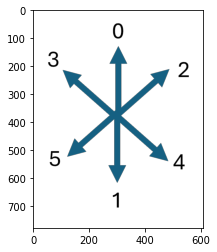

In [9]:
img = plt.imread("action space.png")
plt.imshow(img)

### test

In [11]:
# Create an instance of the custom environment
env = CarEnv(10)

# Example of using the environment
obs = env.reset()
score = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('Score:', score)

Score: -10.22463042798373


In [20]:
env = CarEnv(10,False)
obs = env.reset()


0.04812323229911511


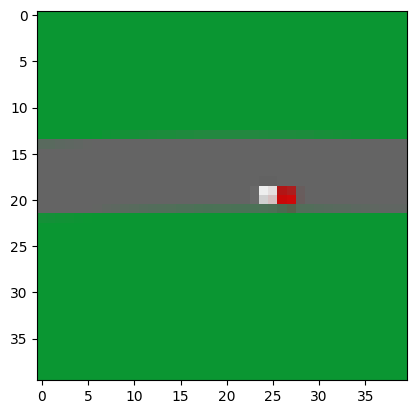

In [21]:
# Size of the image is reduced to make training faster
action = env.action_space.sample()
obs, reward, done, _ = env.step(0)

print(reward)
fig = plt.figure
plt.imshow(obs)

### DL models

In [1]:
import torch
import pandas as pd
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
from deep_Q_newtork import QNetwork, OtherQNetwork, EpsilonGreedy, MinimumExponentialLR, DQNAgent
%aimport deep_Q_newtork


In [13]:
env = CarEnv(10, display=True)
obs = env.reset()
obstensor = CarEnv.obs2tensor(obs, device)

model = QNetwork(action_dim).to(device)

model(obstensor)

tensor([[4.8926, 3.4297, 2.4360, 0.3657, 0.7470, 1.8482]],
       grad_fn=<AddmmBackward0>)

In [28]:
env = CarEnv(30, False)

loss_fn = torch.nn.MSELoss()

NUMBER_OF_TRAININGS = 1

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(action_dim).to(device)
    target_q_network = QNetwork(action_dim).to(device)
    optimizer = torch.optim.AdamW(
        q_network.parameters(), lr=0.004, amsgrad=True)
    epsilon_greedy = EpsilonGreedy(
        epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(
        optimizer, lr_decay=0.99, min_lr=0.0001)

    # Train the q-network
    dqn_agent = DQNAgent(env=env,
                         q_network=q_network,
                         target_q_network=target_q_network,
                         target_q_network_sync_period=50,
                         device=device,
                         gamma=0.85,
                         frame_skipping=4,
                         )

    dqn_agent.train(num_episodes=300,
                    batch_size=128,
                    loss_fn=loss_fn,
                    epsilon_greedy=epsilon_greedy,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    )

# Save the action-value estimation function

torch.save(q_network, "models/dqn2_q_network.pth")

  0%|          | 0/999 [00:00<?, ?it/s]

Episode 1 - Reward: 42.809186196362155


c:\Users\bcbav\.vscode\environnement_ipython\INF581\car_project\Projet\deep_Q_newtork.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_tensor = torch.tensor(
c:\Users\bcbav\.vscode\environnement_ipython\INF581\car_project\Projet\deep_Q_newtork.py:210: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_rewards_tensor = torch.tensor(
c:\Users\bcbav\.vscode\environnement_ipython\INF581\car_project\Projet\deep_Q_newtork.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dones_tensor = torch.tensor(


Episode 2 - Reward: 49.52129724744407
Episode 3 - Reward: 32.1678724527976


399.023761992264
480.97944191522663


KeyboardInterrupt: 

In [30]:
# fine tune agent with the new q_network
# gamma increased => focus more on future rewards
# frame_skipping decreased
# more frequent target network sync

q_network = torch.load("models/dqn2_q_network.pth", map_location=device)
dqn_agent = DQNAgent(env=env,
                     q_network=q_network,
                     target_q_network=target_q_network,
                     target_q_network_sync_period=30,
                     device=device,
                     gamma=0.9,
                     frame_skipping=2,
                     )

dqn_agent.train(num_episodes=300,
                batch_size=128,
                loss_fn=loss_fn,
                epsilon_greedy=epsilon_greedy,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
                )


torch.save(q_network, "models/fined_dqn2_q_network.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

Episode 1 - Reward: 26.23798340408639
Episode 2 - Reward: 37.26201063010141


KeyboardInterrupt: 

In [33]:
env.close()

In [34]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn_agent.result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

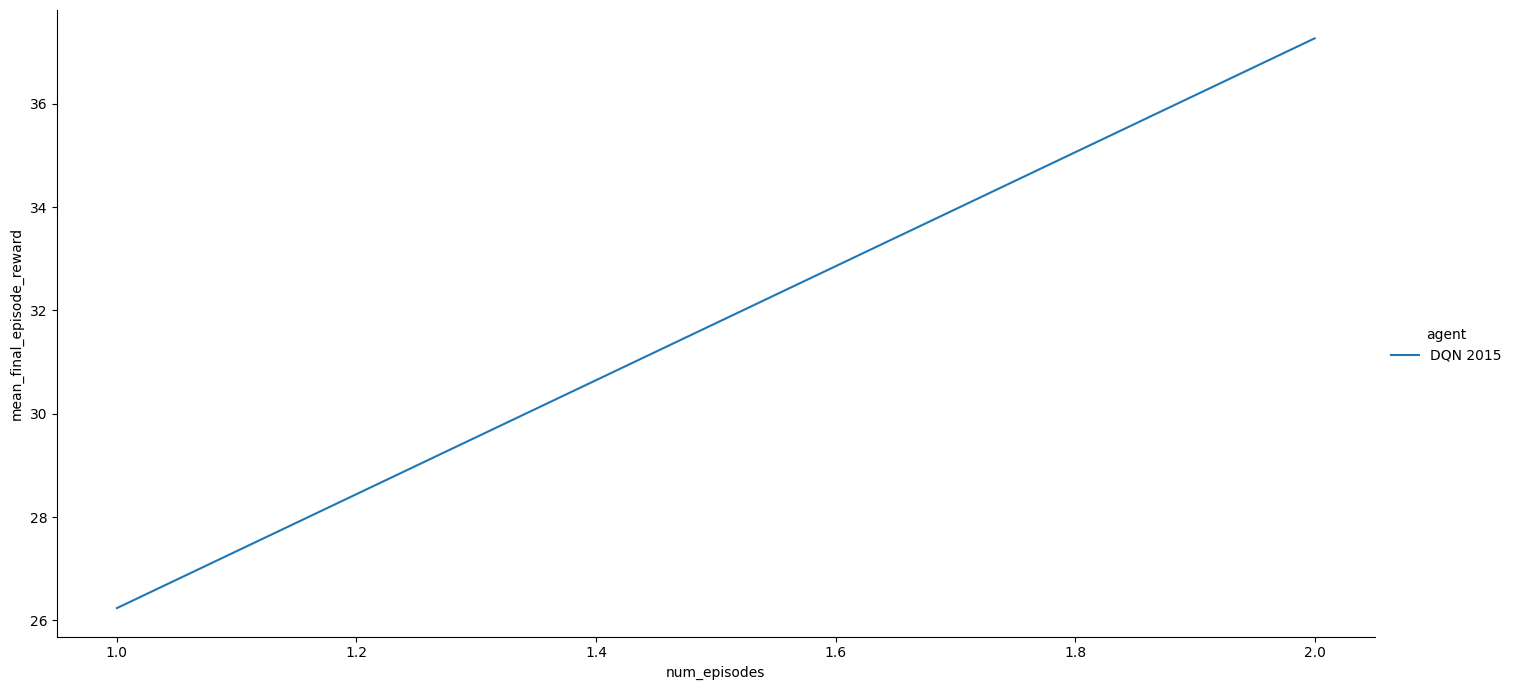

In [35]:
g = sns.relplot(x="num_episodes",
                y="mean_final_episode_reward",
                kind="line",
                hue="agent",
                estimator=None,
                units="training_index",
                data=dqn2_trains_result_df,
                height=7,
                aspect=2)

In [14]:
q_network = torch.load("models/verygood.pth", map_location=device)

In [17]:
import pygame as pg

# Create an instance of the custom environment
env = CarEnv(300,display=True, evaluation=False, draw_central_line=True)

# Example of using the environment
obs = env.reset()
score = 0

while True:
    obstensor = CarEnv.obs2tensor(obs, device)
    action = q_network(obstensor).argmax(dim=1)
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break
print(score)

2550.9333650882368
